## Functions

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from scipy.stats import ttest_rel,wilcoxon

### load data

In [5]:
## load and check BOLD

import os
def fill_nan(df):
    
    df.columns = range(df.shape[1])
    nan_locations = df.isna().stack()[df.isna().stack()].index.tolist()
    for loc in nan_locations:
        row, col = loc
        if col == 0:  
            df.iloc[row, col] = np.nanmean(df.iloc[row, col+1:col+3])
        elif col == df.shape[1] - 1:  
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-2:col])
        else:  
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-1:col+2])
    
    df.columns = df.columns.astype(str)
    return df

def check_df(df):
    cols = df.columns
    df = fill_nan(df)
    df.columns = cols
    return df
    
def read_bold(sub,run_label):
    bold_ctx = pd.read_csv(os.path.join(bold_path,sub,run_label,schaefer+'.csv'))
    bold_sub = pd.read_csv(os.path.join(bold_path,sub,run_label,'hcp.csv'))
    bold = pd.concat([bold_ctx,bold_sub],axis=1)
    bold = check_df(bold)
    return bold
    
schaefer = '100'
atlas = pd.read_csv(f"/data/dy/atlas/schaefer{schaefer}x7_MNI.csv")
RSNs = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
ICNs = RSNs+['Sub']
icn_ls = atlas['ICN'].tolist()+['Sub' for _ in range(19)]
n_roi = int(schaefer)+19
upper_mask = np.triu(np.ones((n_roi, n_roi), dtype=bool), k=1)

bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

roi_ls = read_bold(sub_ls[0],'baseline').columns.tolist()
atlas['Name'] = roi_ls[:-19]

In [8]:
### load measuremnts

def fun_match_scale(scale,timepoint):
    result = pd.DataFrame([])
    df = scale.copy()
    process = df[df['condition'] == timepoint]
    for sub in sub_ls:
        if(sub in process.index):
            result = pd.concat([result,process.loc[sub,:]],axis=1)
    return result.T

madrs = pd.read_csv('/data/dy/TIS_MDD/Scales/madrs.csv',index_col='sub') ## MADRS_all
gad7 = pd.read_csv('/data/dy/TIS_MDD/Scales/gad7.csv',index_col='sub') ## GAD7_ALL
hama = pd.read_csv('/data/dy/TIS_MDD/Scales/hama.csv',index_col='sub') ## HAMA_all
hamd = pd.read_csv('/data/dy/TIS_MDD/Scales/hamd.csv',index_col='sub') ## HAMD_all
phq9 = pd.read_csv('/data/dy/TIS_MDD/Scales/phq9.csv',index_col='sub') ## PHQ9_ALL
psqi = pd.read_csv('/data/dy/TIS_MDD/Scales/psqi.csv',index_col='sub') ## PSQI_ALL
qids = pd.read_csv('/data/dy/TIS_MDD/Scales/qids.csv',index_col='sub') ## QIDS_all
sf36 = pd.read_csv('/data/dy/TIS_MDD/Scales/sf36.csv',index_col='sub') ## SF36_all 
shaps = pd.read_csv('/data/dy/TIS_MDD/Scales/shaps.csv',index_col='sub') ## SHAPS_all
shaps['condition'] = shaps['target']

### functions for plotting

In [10]:
import ptitprince as pt
import statsmodels.formula.api as smf

def p_star(p):
    if(p>0.05):
        return 'n.s.'
    elif(p>0.01):
        return '*'
    elif(p>0.001):
        return '**'
    else:
        return '***'
def regress_out(df,y_ls,x_ls):
    Y = np.array(df.loc[:,y_ls]);x = np.array(df.loc[:,x_ls])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]

    return pd.DataFrame(Y_resid,index=df.index,columns=y_ls)

def longitudinal_plot_wise(df,value_col,time_order,
                      subj_col = 'sub',time_col='condition',figsize = (10,6),p_values = [],title=None,
                      value_label=None,display_labels=None,palette=None,regress=False,regress_col=None):
    if(display_labels==None):
        display_labels = time_order
    if(value_label==None):
        value_label = value_col
    if(palette == None):
        palette = sns.color_palette("husl", len(time_order))
    if(regress and regress_col==None):
        regress_col = ['age','sex_id']
    
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    
    pt.RainCloud(x=time_col, y=value_col, data=df, order=time_order, palette=palette,
                     bw=.2, width_viol=1, width_box=.4, offset=.25,alpha=.75, move=-0.0, ax=ax, orient='v',point_size=4)
    
    y_max = df[value_col].max()
    y_min = df[value_col].min()
    data_range = y_max - y_min
    step = data_range*.15
    ax.set_ylim(y_min - data_range*0.05,
                y_max + data_range*0.1 + len(time_order)*step)
    ax.set_xlim(-.8,len(time_order)-.6)
    
    ax.set_xlabel('')
    ax.set_xticklabels(display_labels, fontsize=18)
    ax.set_xticks(range(len(time_order)))
    ax.set_ylabel(value_label,labelpad=10, fontsize=20)
    if(title!=None):
        ax.set_title(title,fontsize=20)

    h = data_range * 0.04
    current_y = y_max + data_range*0.05
    
    a = df[df['condition']==time_order[0]];a.index=a['sub']
    b = df[df['condition']==time_order[1]];b.index=b['sub']
    valid_index = pd.concat([a,b],axis=1).dropna(axis=0).index.tolist()
    _,p =  ttest_rel(a.loc[valid_index,value_col],b.loc[valid_index,value_col])
    plt.plot([0,0,1,1],[current_y,current_y+h,current_y+h,current_y],lw=1.2, c='k')
    plt.text(1/2, current_y+h, p_star(p), ha='center', va='bottom', fontsize=15)
    if(len(time_order)==3):
        current_y+= step
        a = df[df['condition']==time_order[1]];a.index=a['sub']
        b = df[df['condition']==time_order[2]];b.index=b['sub']
        valid_index = pd.concat([a,b],axis=1).dropna(axis=0).index.tolist()
        _,p =  ttest_rel(a.loc[valid_index,value_col],b.loc[valid_index,value_col])
        plt.plot([1,1,2,2],[current_y,current_y+h,current_y+h,current_y],lw=1.2, c='k')
        plt.text(3/2, current_y+h, p_star(p), ha='center', va='bottom', fontsize=15)
        current_y+= step
        a = df[df['condition']==time_order[0]];a.index=a['sub']
        b = df[df['condition']==time_order[2]];b.index=b['sub']
        valid_index = pd.concat([a,b],axis=1).dropna(axis=0).index.tolist()
        _,p =  ttest_rel(a.loc[valid_index,value_col],b.loc[valid_index,value_col])
        plt.plot([0,0,2,2],[current_y,current_y+h,current_y+h,current_y],lw=1.2, c='k')
        plt.text(1, current_y+h, p_star(p), ha='center', va='bottom', fontsize=15)
    
    x_pos = {t:i for i,t in enumerate(time_order)}
    for sid, g in df.groupby(subj_col):
        g = g.dropna(subset=[value_col]).sort_values(time_col)
        if g[time_col].nunique() >= 2:
            xs = [x_pos[t] for t in g[time_col]]
            ys = g[value_col].to_list()
            ax.plot(xs, ys, color='0.78', alpha=0.55, linewidth=1)

In [11]:
def find_all_scale(scale,col_name,times=['pre','5th','4week']):
    result = pd.DataFrame([])
    for time in times:
        a = pd.DataFrame(fun_match_scale(scale,time)[col_name])
        a['time'] = [time for _ in range(a.shape[0])]
        result = pd.concat([result,a])
    result['sub'] = result.index
    return result

## Plot

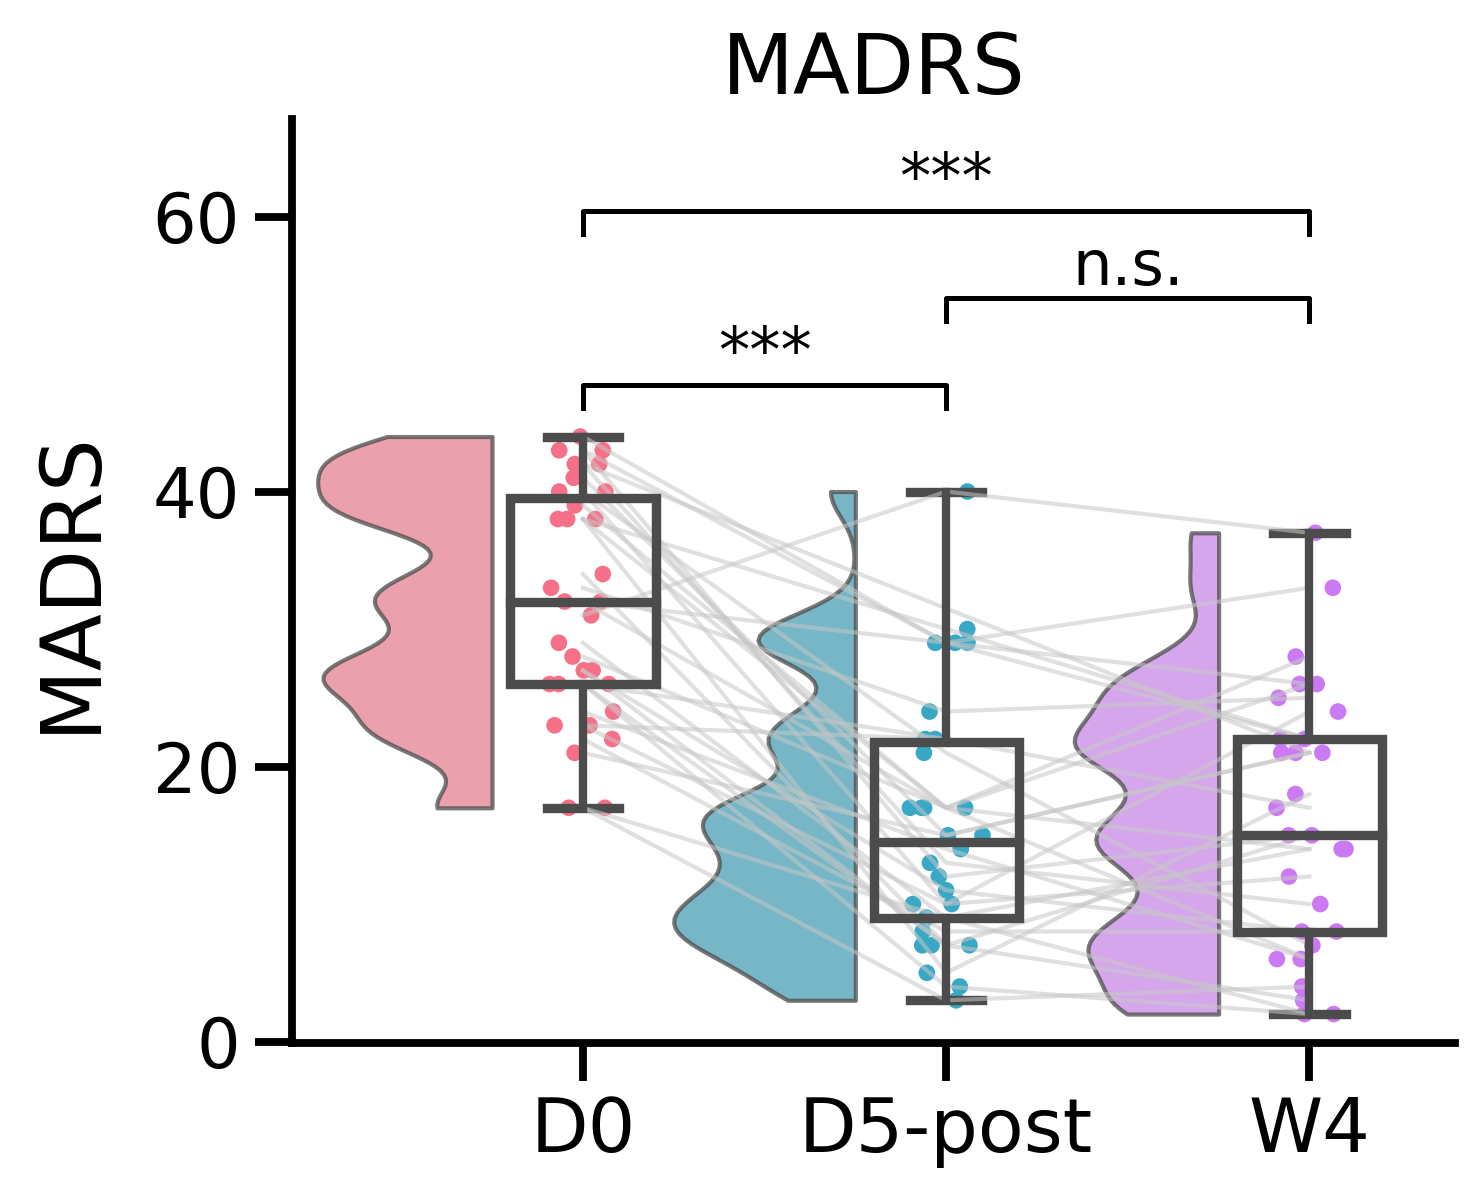

In [12]:
col_name = 'MADRS_all'
df = find_all_scale(madrs,col_name)
df.columns = [col_name,'condition','sub']
df[col_name] = np.array(df[col_name]).astype(np.float64)
time_order=['pre','5th','4week']
display_labels=['D0','D5-post','W4']
palette=['#f67088','#38a8c5','#cc79f4']
longitudinal_plot_wise(df=df,value_col=col_name,time_order=time_order,
                       figsize = (5,4),p_values = [],title=col_name[:-4],
                      value_label=col_name[:-4],display_labels=display_labels,
                       palette=palette)

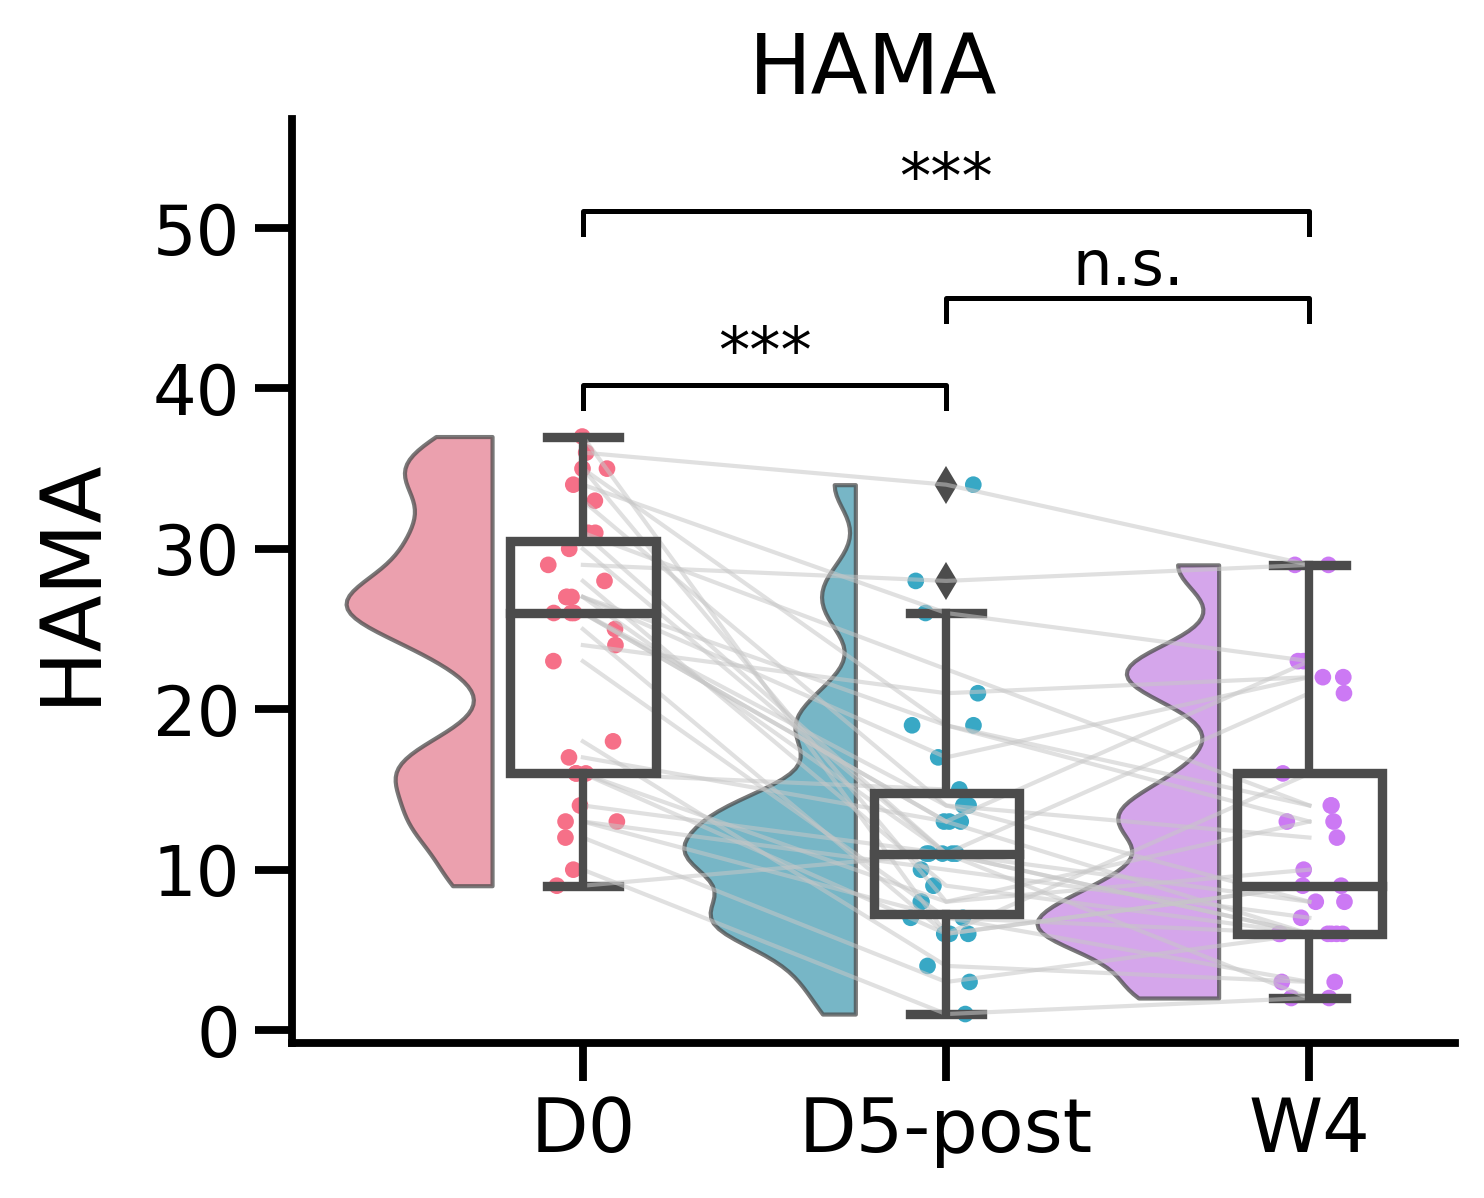

In [13]:
col_name = 'HAMA_all'
df = find_all_scale(hama,col_name)
df.columns = [col_name,'condition','sub']
df[col_name] = np.array(df[col_name]).astype(np.float64)
time_order=['pre','5th','4week']
display_labels=['D0','D5-post','W4']
palette=['#f67088','#38a8c5','#cc79f4']
longitudinal_plot_wise(df=df,value_col=col_name,time_order=time_order,
                       figsize = (5,4),p_values = [],title=col_name[:-4],
                      value_label=col_name[:-4],display_labels=display_labels,
                       palette=palette)

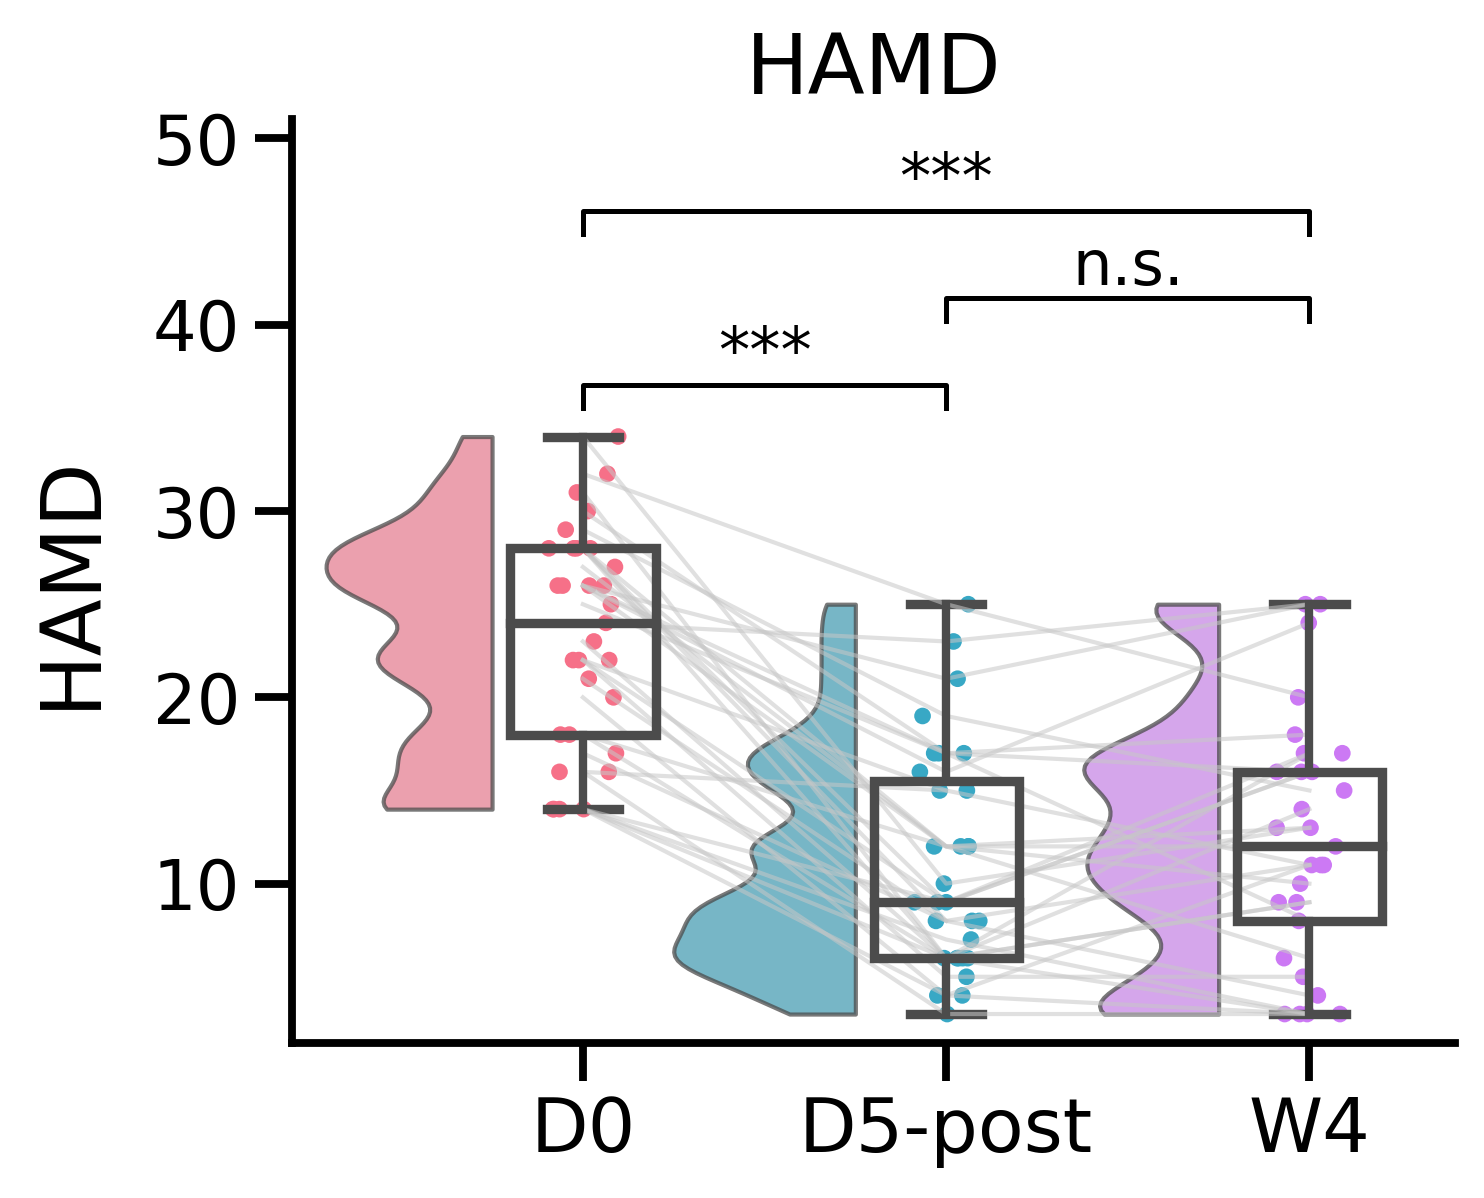

In [14]:
col_name = 'HAMD_all'
df = find_all_scale(hamd,col_name)
df.columns = [col_name,'condition','sub']
df[col_name] = np.array(df[col_name]).astype(np.float64)
time_order=['pre','5th','4week']
display_labels=['D0','D5-post','W4']
palette=['#f67088','#38a8c5','#cc79f4']
longitudinal_plot_wise(df=df,value_col=col_name,time_order=time_order,
                       figsize = (5,4),p_values = [],title=col_name[:-4],
                      value_label=col_name[:-4],display_labels=display_labels,
                       palette=palette)

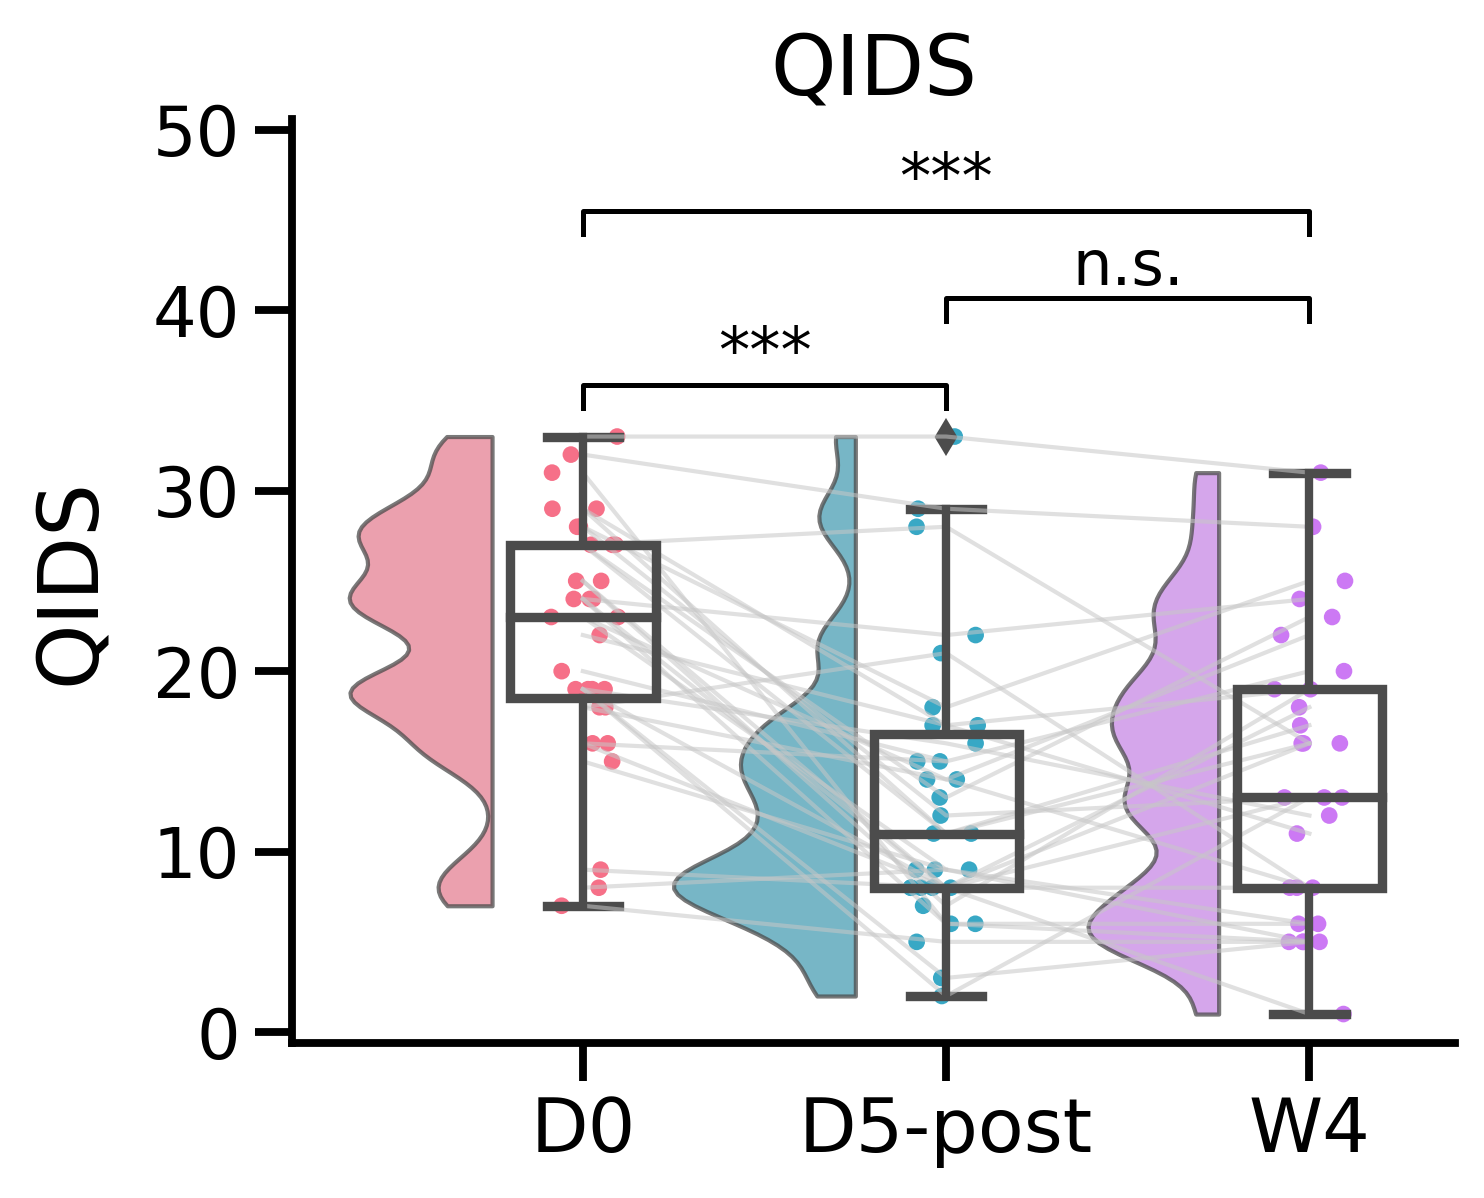

In [15]:
col_name = 'QIDS_all'
df = find_all_scale(qids,col_name)
df.columns = [col_name,'condition','sub']
df[col_name] = np.array(df[col_name]).astype(np.float64)
time_order=['pre','5th','4week']
display_labels=['D0','D5-post','W4']
palette=['#f67088','#38a8c5','#cc79f4']
longitudinal_plot_wise(df=df,value_col=col_name,time_order=time_order,
                       figsize = (5,4),p_values = [],title=col_name[:-4],
                      value_label=col_name[:-4],display_labels=display_labels,
                       palette=palette)

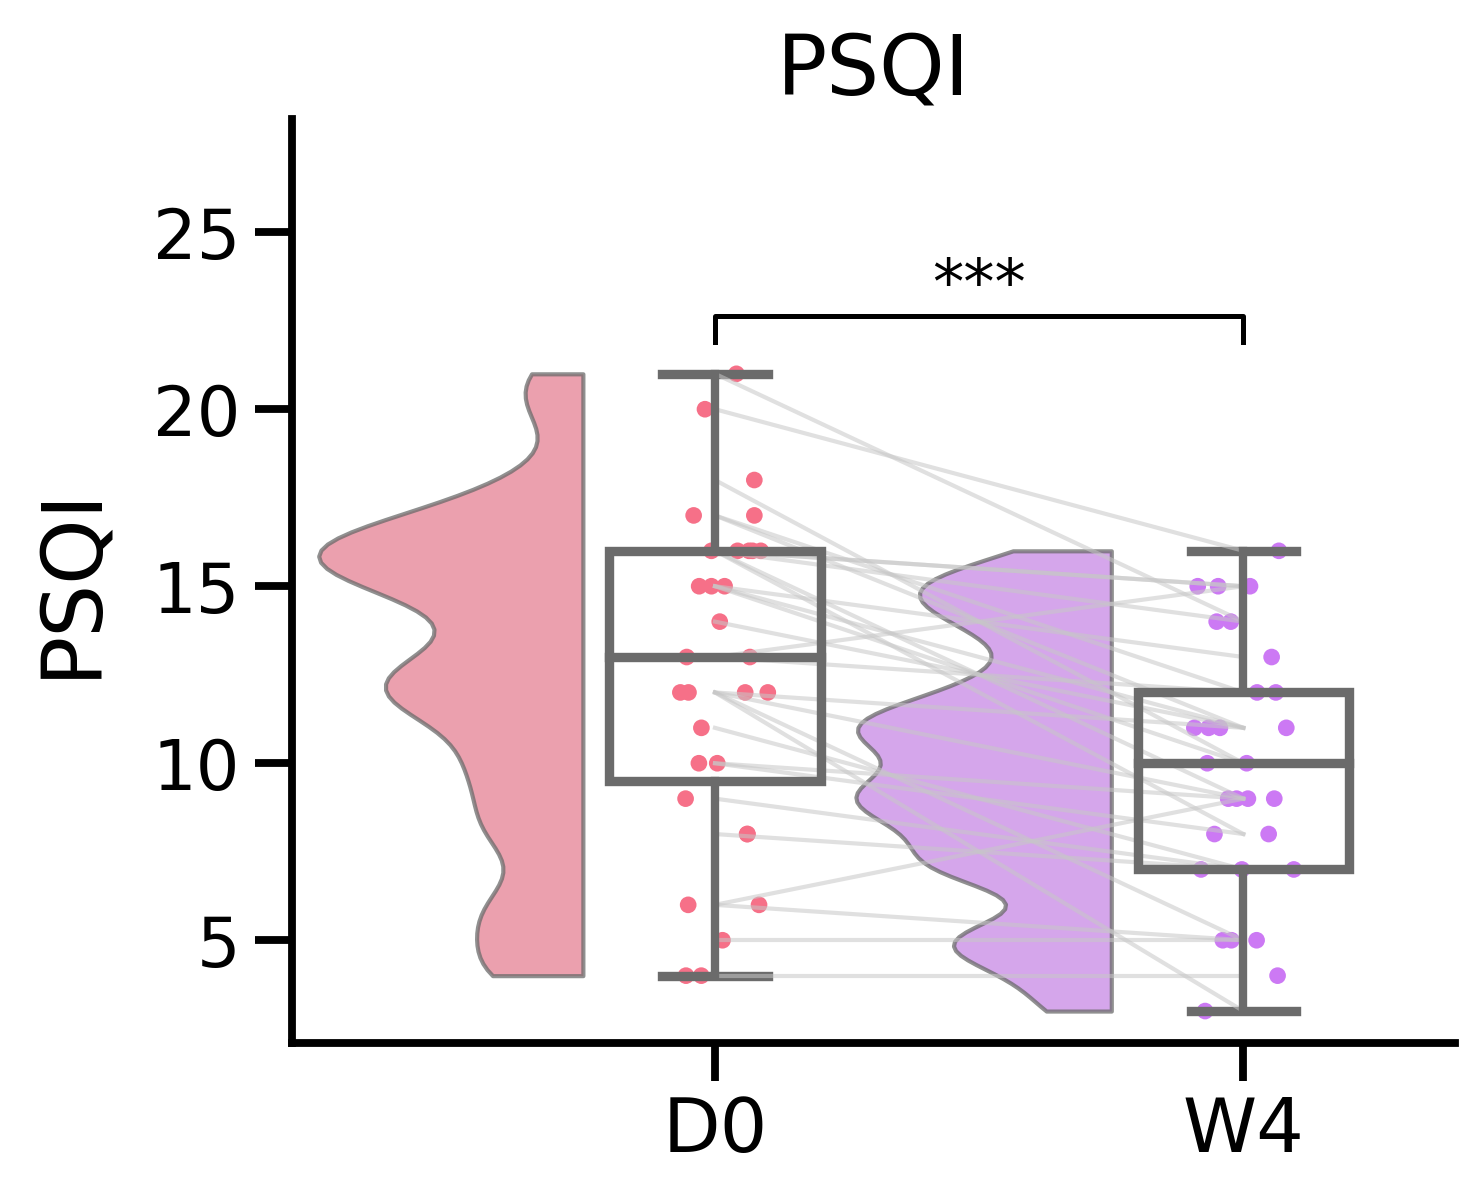

In [16]:
col_name = 'PSQI_ALL'
time_order=['pre','4week']
df = find_all_scale(psqi,col_name,time_order)
df.columns = [col_name,'condition','sub']
df[col_name] = np.array(df[col_name]).astype(np.float64)
display_labels=['D0','W4']
palette=['#f67088','#cc79f4']
longitudinal_plot_wise(df=df,value_col=col_name,time_order=time_order,
                       figsize = (5,4),p_values = [],title=col_name[:-4],
                      value_label=col_name[:-4],display_labels=display_labels,
                       palette=palette)